In [2]:
import pandas as pd
import torch
import numpy as np
import torch.nn as nn

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [4]:
df = pd.read_csv("train.csv")

In [5]:
df.head()

,TRIP_ID,CALL_TYPE,ORIGIN_CALL,ORIGIN_STAND,TAXI_ID,TIMESTAMP,DAY_TYPE,MISSING_DATA,POLYLINE
0,1372636858620000589,C,NaN,NaN,20000589,1372636858,A,False,"[[-8.618643,41.141412],[-8.618499,41.141376],[..."
1,1372637303620000596,B,NaN,7.0,20000596,1372637303,A,False,"[[-8.639847,41.159826],[-8.640351,41.159871],[..."
2,1372636951620000320,C,NaN,NaN,20000320,1372636951,A,False,"[[-8.612964,41.140359],[-8.613378,41.14035],[-..."
3,1372636854620000520,C,NaN,NaN,20000520,1372636854,A,False,"[[-8.574678,41.151951],[-8.574705,41.151942],[..."
4,1372637091620000337,C,NaN,NaN,20000337,1372637091,A,False,"[[-8.645994,41.18049],[-8.645949,41.180517],[-..."


In [6]:
df["target"] = df["POLYLINE"].apply(lambda x : np.float32(max((x.count("[") - 2) *15, 0)))

In [7]:
df['call_A'] = df["CALL_TYPE"].apply(lambda x : int(x == 'A'))
df['call_B'] = df["CALL_TYPE"].apply(lambda x : int(x == 'B'))
df['call_C'] = df["CALL_TYPE"].apply(lambda x : int(x == 'C'))

In [8]:
df = df.loc[df['MISSING_DATA'] == False]
df = df.loc[df['target'] > 0]


In [9]:
def one_hot(str):
    if str == 'A':
        return [1,0,0]
    elif str == 'B':
        return [0,1,0]
    elif str == 'C':
        return [0,0,1]
    else:
        return None

In [10]:
# df['CALL_TYPE'] = df['CALL_TYPE'].apply(lambda x: one_hot(x))
# df['DAY_TYPE'] = df['DAY_TYPE'].apply(lambda x: one_hot(x))
# df = df.loc[df['CALL_TYPE'] != None]
# df = df.loc[df['DAY_TYPE'] != None]

In [11]:
from datetime import datetime
def parse_time(x):
    dt = datetime.fromtimestamp(x["TIMESTAMP"])
    return dt.year, dt.month, dt.day, dt.hour, dt.weekday()

In [12]:
train_id_mean = df['TAXI_ID'].mean()
train_id_std = df['TAXI_ID'].std()
df['TAXI_ID'] = (df['TAXI_ID'] - train_id_mean)/ train_id_std

In [13]:
taxi_ids = set()
for ind, r in df.iterrows():
    taxi_ids.add(r['TAXI_ID'])
taxi_id_to_mean = {}
for i in taxi_ids:
    taxi_id_to_mean[i] = df[df['TAXI_ID'] == i]['target'].mean()

In [14]:
def apply_mean(taxi_id):
    return taxi_id_to_mean[taxi_id]

In [15]:
df['TAXI_ID_MEAN'] = df['TAXI_ID'].apply(apply_mean)
df.head()

,TRIP_ID,CALL_TYPE,ORIGIN_CALL,ORIGIN_STAND,TAXI_ID,TIMESTAMP,DAY_TYPE,MISSING_DATA,POLYLINE,target,call_A,call_B,call_C,TAXI_ID_MEAN
0,1372636858620000589,C,NaN,NaN,1.136256,1372636858,A,False,"[[-8.618643,41.141412],[-8.618499,41.141376],[...",330.0,0,0,1,694.473022
1,1372637303620000596,B,NaN,7.0,1.169448,1372637303,A,False,"[[-8.639847,41.159826],[-8.640351,41.159871],[...",270.0,0,1,0,728.770874
2,1372636951620000320,C,NaN,NaN,-0.139281,1372636951,A,False,"[[-8.612964,41.140359],[-8.613378,41.14035],[-...",960.0,0,0,1,707.499146
3,1372636854620000520,C,NaN,NaN,0.809073,1372636854,A,False,"[[-8.574678,41.151951],[-8.574705,41.151942],[...",630.0,0,0,1,808.640808
4,1372637091620000337,C,NaN,NaN,-0.058671,1372637091,A,False,"[[-8.645994,41.18049],[-8.645949,41.180517],[-...",420.0,0,0,1,758.926819


In [16]:
def normalize(col_name):
    df[col_name] = np.float32((df[col_name] - df[col_name].mean())/df[col_name].std())

In [17]:
def parse_num(str, index):
    comma_pos = str.find(',')
    if comma_pos == -1:
        return None
    if index == 0:
        return np.float32(str[2:comma_pos])
    else:
        return np.float32(str[comma_pos + 1:str.find(']')])

In [18]:
df['Init_longitude'] = df['POLYLINE'].apply(lambda x : parse_num(x,0))
df['Init_latitude'] = df['POLYLINE'].apply(lambda x : parse_num(x,1))
df = df.loc[df['Init_longitude'] != None]
df = df.loc[df['Init_latitude'] != None]
train_long_mean = df['Init_longitude'].mean()
train_lat_mean = df['Init_latitude'].mean()
train_long_std = df['Init_longitude'].std()
train_lat_std = df['Init_latitude'].std()
normalize('Init_longitude')
normalize('Init_latitude')

In [19]:
df.head()

,TRIP_ID,CALL_TYPE,ORIGIN_CALL,ORIGIN_STAND,TAXI_ID,TIMESTAMP,DAY_TYPE,MISSING_DATA,POLYLINE,target,call_A,call_B,call_C,TAXI_ID_MEAN,Init_longitude,Init_latitude
0,1372636858620000589,C,NaN,NaN,1.136256,1372636858,A,False,"[[-8.618643,41.141412],[-8.618499,41.141376],[...",330.0,0,0,1,694.473022,0.961090,0.961183
1,1372637303620000596,B,NaN,7.0,1.169448,1372637303,A,False,"[[-8.639847,41.159826],[-8.640351,41.159871],[...",270.0,0,1,0,728.770874,0.786753,1.004535
2,1372636951620000320,C,NaN,NaN,-0.139281,1372636951,A,False,"[[-8.612964,41.140359],[-8.613378,41.14035],[-...",960.0,0,0,1,707.499146,1.007784,0.958705
3,1372636854620000520,C,NaN,NaN,0.809073,1372636854,A,False,"[[-8.574678,41.151951],[-8.574705,41.151942],[...",630.0,0,0,1,808.640808,1.322562,0.985998
4,1372637091620000337,C,NaN,NaN,-0.058671,1372637091,A,False,"[[-8.645994,41.18049],[-8.645949,41.180517],[-...",420.0,0,0,1,758.926819,0.736210,1.053185


In [20]:
train_set = torch.reshape(torch.tensor(df['call_A'].values),(-1,1))
col_list = ['call_B', 'call_C','TAXI_ID', 'Init_longitude', 'Init_latitude', 'TAXI_ID_MEAN']
for col_name in col_list:
#     print(train_set.dtype)
    train_set = torch.cat((train_set,torch.reshape(torch.from_numpy(df[col_name].values),(-1,1))),1)

In [21]:
train_set = train_set.type('torch.FloatTensor')

In [22]:
target_set = torch.reshape(torch.tensor(df['target'].values),(-1,1))

In [23]:
train_set[0]

tensor([  0.0000,   0.0000,   1.0000,   1.1363,   0.9611,   0.9612, 694.4730])

In [24]:
class MLP_Regressor(torch.nn.Module):
    def __init__(self, in_dim, hidden_dim, out_dim = 1):
        super(MLP_Regressor, self).__init__() #Refers to the fact that this is a subclass of nn.Module and is inheriting all methods
        
        out_dim = 1
  
        self.in_dim = in_dim
        self.hidden_dim = hidden_dim
        self.out_dim = out_dim
        self.linear1 = nn.Linear(self.in_dim, self.hidden_dim)
        self.linear2 = nn.Linear(self.hidden_dim, self.out_dim)
        
                
        self.fc = torch.nn.Sequential(
            nn.Linear(self.in_dim, self.hidden_dim),
            nn.ReLU(),
            nn.Linear(self.hidden_dim, self.hidden_dim * 4),
            nn.ReLU(),
            nn.Linear(self.hidden_dim * 4, self.hidden_dim * 2),
            nn.ReLU(),
            nn.Linear(self.hidden_dim * 2, self.out_dim)
        )

    
    def forward(self, x):
        x = self.fc(x)
        x = x.squeeze(1)
        return x

In [25]:
targets_mlp = torch.reshape(torch.from_numpy(df['target'].values),(-1,1))

In [26]:
len(targets_mlp)

1674152

In [28]:
batch_size = 1024
lst_all = list(zip(train_set, targets_mlp))
np.random.shuffle(lst_all)
#lst_all = lst_all[:int(len(lst_all) / 2)]
lst_train = lst_all[:int(len(lst_all) * 0.8)]
lst_valid = lst_all[int(len(lst_all) * 0.8):]
len_train = len(lst_train)
print(len(lst_train))
print(len(lst_valid))
#print(lst_train[0])
trainloader = torch.utils.data.DataLoader(lst_train , batch_size=batch_size, shuffle=True, num_workers=2)
validloader = torch.utils.data.DataLoader(lst_valid , batch_size=batch_size, shuffle=False, num_workers=2)

1339321
334831


In [58]:
mlp_model = MLP_Regressor(7, 14, 1).to(device)
lr_mlp = 5e-6
optimizer = torch.optim.Adam(mlp_model.parameters(), lr = lr_mlp)
criterion = nn.MSELoss()

In [59]:
def get_loss(X, y, model, criterion):
    y_pred = model(X)
    loss = criterion(y_pred, y)
    return torch.sqrt(loss)

In [60]:
def validate(dataloader, model, criterion):
    valid_losses = []
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            loss = get_loss(X, y, model, criterion)
            valid_losses.append(loss.item())
    
    return np.mean(valid_losses)

In [61]:
val_losses = []

In [62]:
models = []
from tqdm import tqdm
for epoch in tqdm(range(10)):

    running_loss = 0.0
    losses = []
    for X, y in trainloader:
        X, y = X.to(device), y.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        loss = get_loss(X, y, mlp_model, criterion)
        losses.append(loss.item())
        loss.backward()
        optimizer.step()

        running_loss += loss.cpu().detach().numpy()
    val_loss = validate(validloader, mlp_model, criterion)
    val_losses.append(val_loss)
    models.append(torch.jit.script(mlp_model))
    print(f'RMSE: {running_loss / len(losses)}')
    print(f'Validation RMSE: {val_loss}')
print('Finished Training')


  0%|          | 0/10 [00:00<?, ?it/s]C:\ProgramData\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:536: UserWarning: Using a target size (torch.Size([1024, 1])) that is different to the input size (torch.Size([1024])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
C:\ProgramData\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:536: UserWarning: Using a target size (torch.Size([953, 1])) that is different to the input size (torch.Size([953])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
C:\ProgramData\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:536: UserWarning: Using a target size (torch.Size([1007, 1])) that is different to the input size (torch.Size([1007])). This will likely lead to incorrect results due to broadcasting. Please e

RMSE: 990.0381542987416
Validation RMSE: 963.9296203053326


 20%|██        | 2/10 [05:21<21:25, 160.68s/it]

RMSE: 972.3252508414265
Validation RMSE: 944.0416351225033


 30%|███       | 3/10 [08:02<18:46, 160.95s/it]

RMSE: 950.3716795101807
Validation RMSE: 920.1787553606413


 40%|████      | 4/10 [10:41<16:02, 160.35s/it]

RMSE: 926.3810529796356
Validation RMSE: 894.3151564291858


 50%|█████     | 5/10 [13:23<13:23, 160.79s/it]

RMSE: 898.8415983240903
Validation RMSE: 864.9845381337203


 60%|██████    | 6/10 [16:04<10:43, 160.82s/it]

RMSE: 868.1897980109632
Validation RMSE: 831.7924058080084


 70%|███████   | 7/10 [18:44<08:01, 160.53s/it]

RMSE: 833.8581344651155
Validation RMSE: 795.6441680254921


 80%|████████  | 8/10 [21:27<05:22, 161.26s/it]

RMSE: 797.281889142611
Validation RMSE: 758.1907695805261


 90%|█████████ | 9/10 [24:09<02:41, 161.57s/it]

RMSE: 760.8155645901275
Validation RMSE: 722.1118048338351


100%|██████████| 10/10 [26:50<00:00, 161.02s/it]

RMSE: 727.8615740621491
Validation RMSE: 691.1192220052084
Finished Training


In [69]:
import matplotlib.pyplot as plt
import random

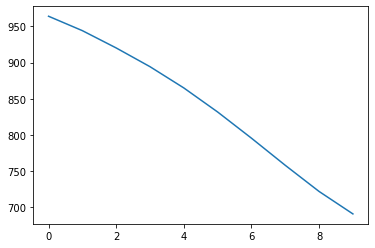

In [66]:
plt.plot(val_losses)

In [71]:
train_set[0]

tensor([  0.0000,   0.0000,   1.0000,   1.1363,   0.9611,   0.9612, 694.4730])

In [92]:
points = []
actuals = []
preds = []
for i in range(10):
    ind = random.randint(0, len(train_set) - 1)
    rd_pt = train_set[ind]
    points.append(rd_pt)
    actual = targets_mlp[ind].item()
    actuals.append(actual)

points = torch.stack(points)
pred_rands = mlp_model(points.to(device)).cpu().detach().numpy()
print(pred_rands)


[428.51968 490.1547  485.61407 816.98865 492.3861  462.0307  509.01178
 513.63403 694.6834  480.31635]


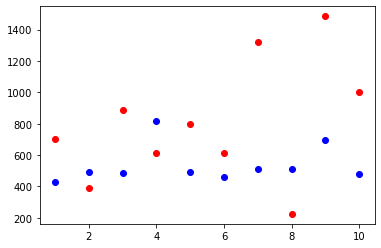

In [94]:
x = [1,2,3,4,5,6,7,8,9,10]
plt.scatter(x, pred_rands, color = 'blue')
plt.scatter(x, actuals, color = 'red')

In [37]:
sum(p.numel() for p in mlp_model.parameters())

2704

In [47]:
model_scripted = torch.jit.script(mlp_model)
#model_scripted.save('final_model.pt')

In [38]:
stands = pd.read_csv("metaData_taxistandsID_name_GPSlocation.csv")
stand_dict = {}
stands.head()
for r, s in stands.iterrows():
    stand_dict[s['ID']] = (np.float32(s['Longitude']), np.float32(s['Latitude']))

In [39]:
df_test = pd.read_csv("test_public.csv")
df_test['call_A'] = df_test["CALL_TYPE"].apply(lambda x : int(x == 'A'))
df_test['call_B'] = df_test["CALL_TYPE"].apply(lambda x : int(x == 'B'))
df_test['call_C'] = df_test["CALL_TYPE"].apply(lambda x : int(x == 'C'))
df_test['TAXI_ID'] = (df_test['TAXI_ID'] - train_id_mean)/train_id_std

df_test['Init_longitude'] = train_long_mean
df_test['Init_latitude'] = train_lat_mean

In [40]:
def apply_mean_test(taxi_id):
    if taxi_id in taxi_id_to_mean:
        return taxi_id_to_mean[taxi_id]
    else:
        return train_id_mean

In [41]:
df_test['TAXI_ID_MEAN'] = df_test['TAXI_ID'].apply(apply_mean_test)

In [42]:
for ind, d in df_test.iterrows():
    if not pd.isna(d['ORIGIN_STAND']):
        #print(d['ORIGIN_STAND'])
        d['Init_longitude'] = stand_dict[d['ORIGIN_STAND']][0]
        d['Init_latitude'] = stand_dict[d['ORIGIN_STAND']][1]
    d['Init_longitude'] = (d['Init_longitude'] - train_long_mean) / train_long_std
    d['Init_latitude'] = (d['Init_latitude'] - train_lat_mean) / train_lat_std

#    df[col_name] = np.float32((df[col_name] - df[col_name].mean())/df[col_name].std())
test_set = torch.reshape(torch.tensor(df_test['call_A'].values),(-1,1))
col_list = ['call_B', 'call_C','TAXI_ID', 'Init_longitude', 'Init_latitude', 'TAXI_ID_MEAN']
#col_list = ['call_B', 'call_C','TAXI_ID', 'Init_longitude', 'Init_latitude']
for col_name in col_list:
#     print(train_set.dtype)
    test_set = torch.cat((test_set,torch.reshape(torch.from_numpy(df_test[col_name].values),(-1,1))),1)
test_set = test_set.type('torch.FloatTensor')

In [52]:
test_set = test_set
preds = mlp_model(test_set.to(device)).cpu().detach().numpy()
#preds = model(test_set.to(device))


In [53]:
len(test_set)

320

In [54]:
def round_to_multiple(number, multiple):
    return multiple * round(number / multiple)

In [55]:
for i in range(len(preds)):
    preds[i] = round_to_multiple(preds[i], 15)

In [56]:
output_csv = pd.read_csv("sampleSubmission.csv")
output_csv['TRAVEL_TIME'] = preds
#df_test["TRAVEL_TIME"] = 716.43
output_csv.tail()
output_csv.to_csv("my_pred.csv", index=None)


In [97]:
#load model and ouput
m = torch.jit.load('final_model.pt')
m.eval()
p = m(test_set.to(device)).cpu().detach().numpy()
for i in range(len(p)):
    p[i] = round_to_multiple(p[i], 15)
output_csv = pd.read_csv("sampleSubmission.csv")
output_csv['TRAVEL_TIME'] = p
#df_test["TRAVEL_TIME"] = 716.43
output_csv.tail()
output_csv.to_csv("my_pred.csv", index=None)